In [26]:
import numpy as np
import pandas as pd
import sys
sys.path.append("/home/prash/time_series_prediction/src/rnn")
sys.path.append("/home/prash/time_series_prediction/src/")
from RNNPerTStepBinaryClassifier import RNNPerTStepBinaryClassifier
from dataset_loader import TidySequentialDataCSVLoader
import os
import matplotlib.pyplot as plt

## Load the test data

In [27]:
x_train_csv ="/home/prash/time_series_prediction/datasets/toy_overheat/v20200515/classifier_train_test_split/x_train.csv.gz"
x_valid_csv ="/home/prash/time_series_prediction/datasets/toy_overheat/v20200515/classifier_train_test_split/x_valid.csv.gz"
x_test_csv ="/home/prash/time_series_prediction/datasets/toy_overheat/v20200515/classifier_train_test_split/x_test.csv.gz"
y_train_csv ="/home/prash/time_series_prediction/datasets/toy_overheat/v20200515/classifier_train_test_split/y_train.csv.gz"
y_valid_csv ="/home/prash/time_series_prediction/datasets/toy_overheat/v20200515/classifier_train_test_split/y_valid.csv.gz"
y_test_csv = "/home/prash/time_series_prediction/datasets/toy_overheat/v20200515/classifier_train_test_split/y_test.csv.gz"

train_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_train_csv,
    y_csv_path=y_train_csv,
    x_col_names=["temperature"],
    idx_col_names=["sequence_id"],
    y_col_name="did_overheat_binary_label",
    y_label_type='per_tstep'
)

valid_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_valid_csv,
    y_csv_path=y_valid_csv,
    x_col_names=["temperature"],
    idx_col_names=["sequence_id"],
    y_col_name="did_overheat_binary_label",
    y_label_type='per_tstep'
)

test_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_test_csv,
    y_csv_path=y_test_csv,
    x_col_names=["temperature"],
    idx_col_names=["sequence_id"],
    y_col_name="did_overheat_binary_label",
    y_label_type='per_tstep'
)

X_train, y_train = train_vitals.get_batch_data(batch_id=0)
X_valid, y_valid = valid_vitals.get_batch_data(batch_id=0)
X_test, y_test = test_vitals.get_batch_data(batch_id=0)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(405, 200)
(45, 193)
(50, 197)


In [7]:
X_train[0]

array([[ 1.03803492e+00],
       [ 1.91286635e-02],
       [ 8.07188213e-01],
       [ 8.04132879e-01],
       [-6.98462665e-01],
       [ 2.15317178e+00],
       [ 2.26846838e+00],
       [ 1.04049456e+00],
       [ 1.24141812e+00],
       [-2.02511144e+00],
       [-1.86733687e+00],
       [ 2.57158995e-01],
       [-1.02048564e+00],
       [-4.65186149e-01],
       [-1.56641328e+00],
       [ 9.68867362e-01],
       [ 2.45272779e+00],
       [ 1.39203095e+00],
       [ 2.39542916e-01],
       [ 4.03209388e-01],
       [ 1.65816939e+00],
       [-5.14227033e-01],
       [-6.58371985e-01],
       [ 5.00472367e-01],
       [-1.58437505e-01],
       [ 1.26008081e+00],
       [ 2.67756224e+00],
       [ 2.87991714e+00],
       [ 1.27700448e+00],
       [ 5.76496422e-01],
       [ 1.45301342e+00],
       [ 7.78100371e-01],
       [-1.40982822e-01],
       [ 1.63581443e+00],
       [-3.49818282e-02],
       [ 1.25491667e+00],
       [ 1.72119606e+00],
       [ 2.31500983e+00],
       [ 6.3

## Load RNN

In [28]:
best_model_prefix = "/home/prash/results/toy_overheat/rnn_per_tstep/rnn_per_tstep_hiddens=16-layers=1-lr=0.005-dropout=0-weight_decay=0.001-seed=1111-batch_size=-1"

rnn = RNNPerTStepBinaryClassifier(module__rnn_type='GRU',
                  module__n_layers=1,
                  module__n_hiddens=16,
                  module__n_inputs=X_test.shape[-1])
rnn.initialize()
rnn.load_params(f_params=best_model_prefix+'params.pt',
                f_optimizer=best_model_prefix+'optimizer.pt',
                f_history=best_model_prefix+'history.json')

## Plot RNN training history

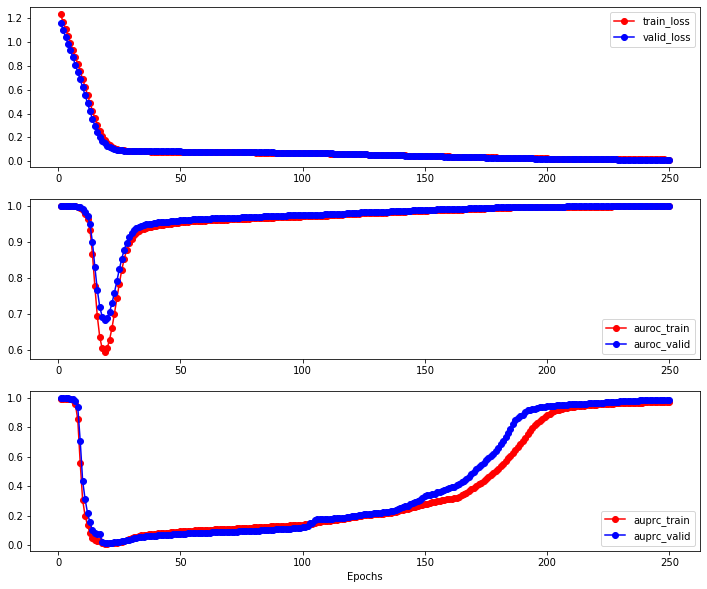

In [29]:
rnn_hist_df = pd.DataFrame(rnn.history_)
f, axs = plt.subplots(3, 1, figsize=(12, 10))
axs[0].plot(rnn_hist_df['epoch'], rnn_hist_df['train_loss'], 'r-o', label='train_loss')
axs[0].plot(rnn_hist_df['epoch'], rnn_hist_df['valid_loss'], 'b-o', label='valid_loss')
axs[0].legend()

axs[1].plot(rnn_hist_df['epoch'], rnn_hist_df['auroc_train'], 'r-o', label='auroc_train')
axs[1].plot(rnn_hist_df['epoch'], rnn_hist_df['auroc_valid'], 'b-o', label='auroc_valid')
axs[1].legend()

axs[2].plot(rnn_hist_df['epoch'], rnn_hist_df['auprc_train'], 'r-o', label='auprc_train')
axs[2].plot(rnn_hist_df['epoch'], rnn_hist_df['auprc_valid'], 'b-o', label='auprc_valid')
axs[2].legend()
axs[2].set_xlabel('Epochs')
plt.legend()
plt.show()

## Plot predictions per timepoint on a few test samples

In [30]:
y_test_pred_proba = rnn.predict_proba(X_test).detach().numpy()

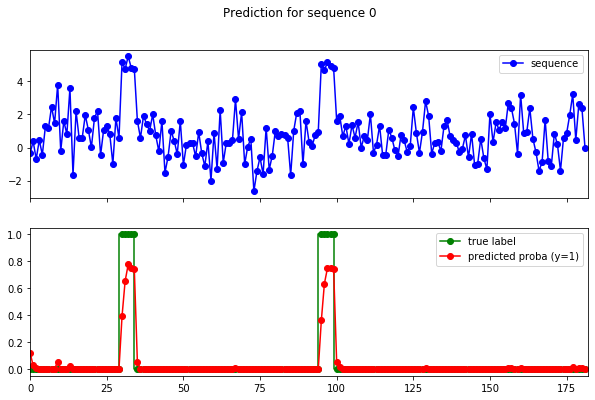

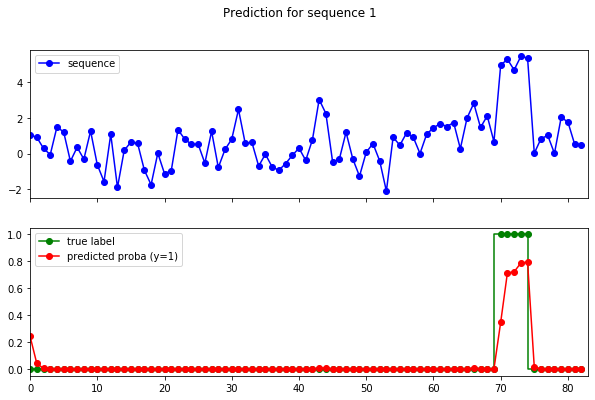

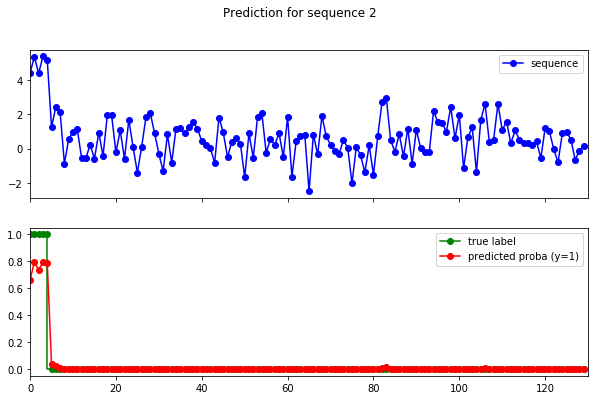

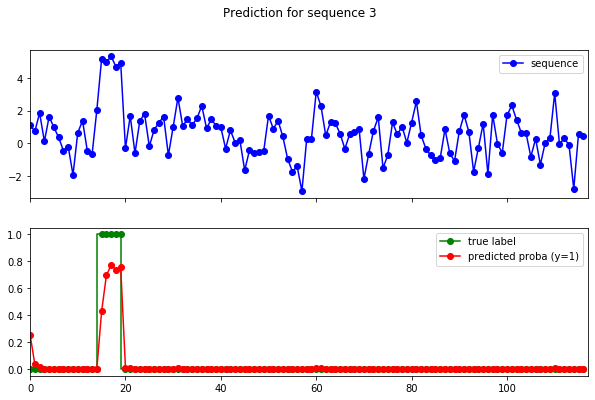

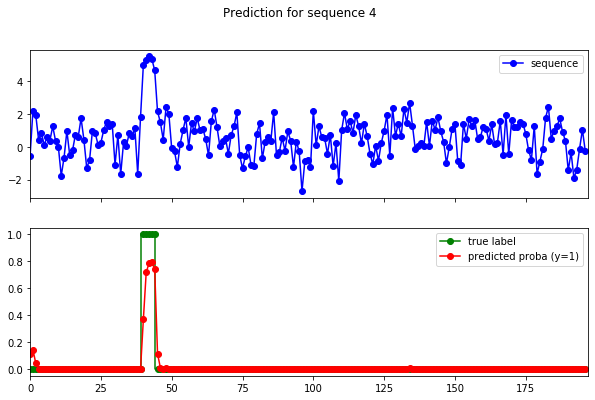

In [33]:
T = y_test.shape[1]
# get the sequence lengths of test sequences
keep_inds = ~(np.all(np.isnan(X_test), axis=-1))
seq_lens_N = np.sum(keep_inds, axis=1)

inds_label_1 = np.flatnonzero(np.any(y_test==1, axis=1))

for i in range(5):
    
    curr_X = X_test[inds_label_1[i], :seq_lens_N[inds_label_1[i]]]
    curr_T = seq_lens_N[inds_label_1[i]]
    curr_y = y_test[inds_label_1[i], :seq_lens_N[inds_label_1[i]]]
    curr_y_pred_probas = y_test_pred_proba[inds_label_1[i], :seq_lens_N[inds_label_1[i]], 1]
    
    f, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
    axs[0].plot(range(curr_T), curr_X, 'b-o', label='sequence')
    axs[1].step(range(curr_T), curr_y, 'g-o', label='true label')
    axs[1].plot(range(curr_T), curr_y_pred_probas, 'r-o', label='predicted proba (y=1)')
    axs[1].set_xlim([0, curr_T])
    
    for ax in axs:
        ax.legend()
    plt.suptitle('Prediction for sequence %d'%i)
    f.savefig('sequence_%d_predictions.png'%i)
    plt.show()

In [23]:
seq_lens_N = np.sum(keep_inds, axis=1)
X_test[inds_label_1[i], :seq_lens_N[inds_label_1[i]]]

array([[-0.5577651 ],
       [ 2.1902978 ],
       [ 1.9522271 ],
       [ 0.43991566],
       [ 0.84306806],
       [ 0.1096116 ],
       [ 0.59500587],
       [ 0.38308755],
       [ 1.2477218 ],
       [ 0.3550674 ],
       [-0.02430235],
       [-1.7626348 ],
       [-0.65355414],
       [ 0.970368  ],
       [-0.5202142 ],
       [-0.20996459],
       [ 0.7327207 ],
       [ 0.60305196],
       [ 1.7379508 ],
       [ 0.4404876 ],
       [-1.2863849 ],
       [-0.81307703],
       [ 0.9494721 ],
       [ 0.826659  ],
       [ 0.13394316],
       [ 0.24534038],
       [ 1.023207  ],
       [ 1.5291802 ],
       [ 1.263285  ],
       [ 1.3912231 ],
       [-1.0873657 ],
       [ 0.70924664],
       [-1.6683931 ],
       [ 0.2736445 ],
       [ 0.04531395],
       [ 0.8335594 ],
       [ 0.63276017],
       [ 1.1194177 ],
       [-1.6416295 ],
       [ 1.8197318 ],
       [ 4.997452  ],
       [ 5.3071017 ],
       [ 5.5039983 ],
       [ 5.3501205 ],
       [ 4.646889  ],
       [ 2

In [22]:
X_test.shape

(50, 197, 1)